In [1]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataLoader
from toolkit.pytorch_tools import NeuralNetwork
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import Normalize
from torchvision.transforms import ToPILImage
from torchvision.transforms import ToTensor
# from torchvision.transforms import RandomHorizontalFlip
# from torchvision.transforms import RandomVerticalFlip
# from torchvision.transforms import RandomRotation
# from torchvision.transforms import RandomPerspective

from torchsummary import summary

import torch
import gc

In [2]:
torch.cuda.empty_cache()
gc.collect()
logger = Logger("main").get_logger()

In [3]:
data = DataFrameCreator()

samples = ["./data/sd1_sample"]

In [4]:
for sample in samples:
    data.load_dataset(
        sample_dir=sample, labels={"non_defective": 0, "defective": 1}
    )
data.split_dataset()
data.info()
data["dataset"].head()

[    INFO    ] Images loaded from ./data/sd1_sample with label non_defective
[    INFO    ] Images loaded from ./data/sd1_sample with label defective
[    INFO    ] Name :          dataset
[    INFO    ] Labels:         {'non_defective': 8733}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (8733, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          train
[    INFO    ] Labels:         {'non_defective': 6113}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (6113, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          validation
[    INFO    ] Labels:         {'non_defective': 1746}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (1746, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          test
[    INFO    ] Labels:         {'non

,img_dir,img_file,img,label,label_enc
0,data/sd1_sample/non_defective,img_00000.jpg,data/sd1_sample/non_defective/img_00000.jpg,non_defective,0
1,data/sd1_sample/non_defective,img_00001.jpg,data/sd1_sample/non_defective/img_00001.jpg,non_defective,0
2,data/sd1_sample/non_defective,img_00002.jpg,data/sd1_sample/non_defective/img_00002.jpg,non_defective,0
3,data/sd1_sample/non_defective,img_00003.jpg,data/sd1_sample/non_defective/img_00003.jpg,non_defective,0
4,data/sd1_sample/non_defective,img_00004.jpg,data/sd1_sample/non_defective/img_00004.jpg,non_defective,0


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_size = (256, 256)

transform = {
    "train": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "validation": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "test": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
}
target_transform = {
    "train": None,
    "validation": None,
    "test": None,
}

loader = CustomImageDataLoader(
    dataset=data,
    image_col="img",
    label_col="label_enc",
    transform=transform,
    target_transform=target_transform,
)
loader.create_dataloaders(batch_size=8)

[    INFO    ] CustomImageDataSet created
[    INFO    ] Setting dataloader subprocesses to 8
[    INFO    ] Dataloaders created


In [6]:
model = NeuralNetwork(name="test", encoder_name="VGG19", encoder_weights="IMAGENET1K_V1", num_classes=3)
model.init_device(device="cpu")

[    INFO    ] Model filename: results/test/20230421_192052.pth
[    INFO    ] Results filename: results/test/20230421_192052.csv
[    INFO    ] Neural Network constructed: test
[    INFO    ] NeuralNetwork(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, k

In [7]:
summary(model, input_size=(3, *input_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [9]:
epochs = 10

model.train_net(epochs=epochs, train_loader=loader["train"], validation_loader=loader["validation"])

[    INFO    ] Model training started
[    INFO    ] Epoch:    0 Loss:  0.1683 Validation loss:  0.0919   
[    INFO    ] Epoch:    1 Loss:  0.0854 Validation loss:  0.0815   
[    INFO    ] Epoch:    2 Loss:  0.0782 Validation loss:  0.0762   
[    INFO    ] Epoch:    3 Loss:  0.0734 Validation loss:  0.0801   
[    INFO    ] Epoch:    4 Loss:  0.0704 Validation loss:  0.0701   
[    INFO    ] Epoch:    5 Loss:  0.0679 Validation loss:  0.0684   
[    INFO    ] Epoch:    6 Loss:  0.0658 Validation loss:  0.0657   
[    INFO    ] Epoch:    7 Loss:  0.0641 Validation loss:  0.0657   
[    INFO    ] Epoch:    8 Loss:  0.0629 Validation loss:  0.0632   
[    INFO    ] Epoch:    9 Loss:  0.0618 Validation loss:  0.0636   


In [10]:
model.results.data

,loss,accuracy,validation_loss,validation_acc
0,0.168271,0.0,0.091934,0.0
1,0.085362,0.0,0.081497,0.0
2,0.078238,0.0,0.076248,0.0
3,0.073408,0.0,0.080081,0.0
4,0.070370,0.0,0.070100,0.0
5,0.067896,0.0,0.068413,0.0
6,0.065780,0.0,0.065695,0.0
7,0.064106,0.0,0.065748,0.0
8,0.062887,0.0,0.063205,0.0
9,0.061801,0.0,0.063558,0.0


In [11]:
model.save_model(epoch=model.results.data.index[-1], loss=model.results.data["loss"].iloc[-1])
model.results.save_data()

[    INFO    ] Model saved to results/test/20230419_221319.pth
[    INFO    ] Results saved to: results/test/20230419_221319.csv


TypeError: 'AxesSubplot' object is not subscriptable

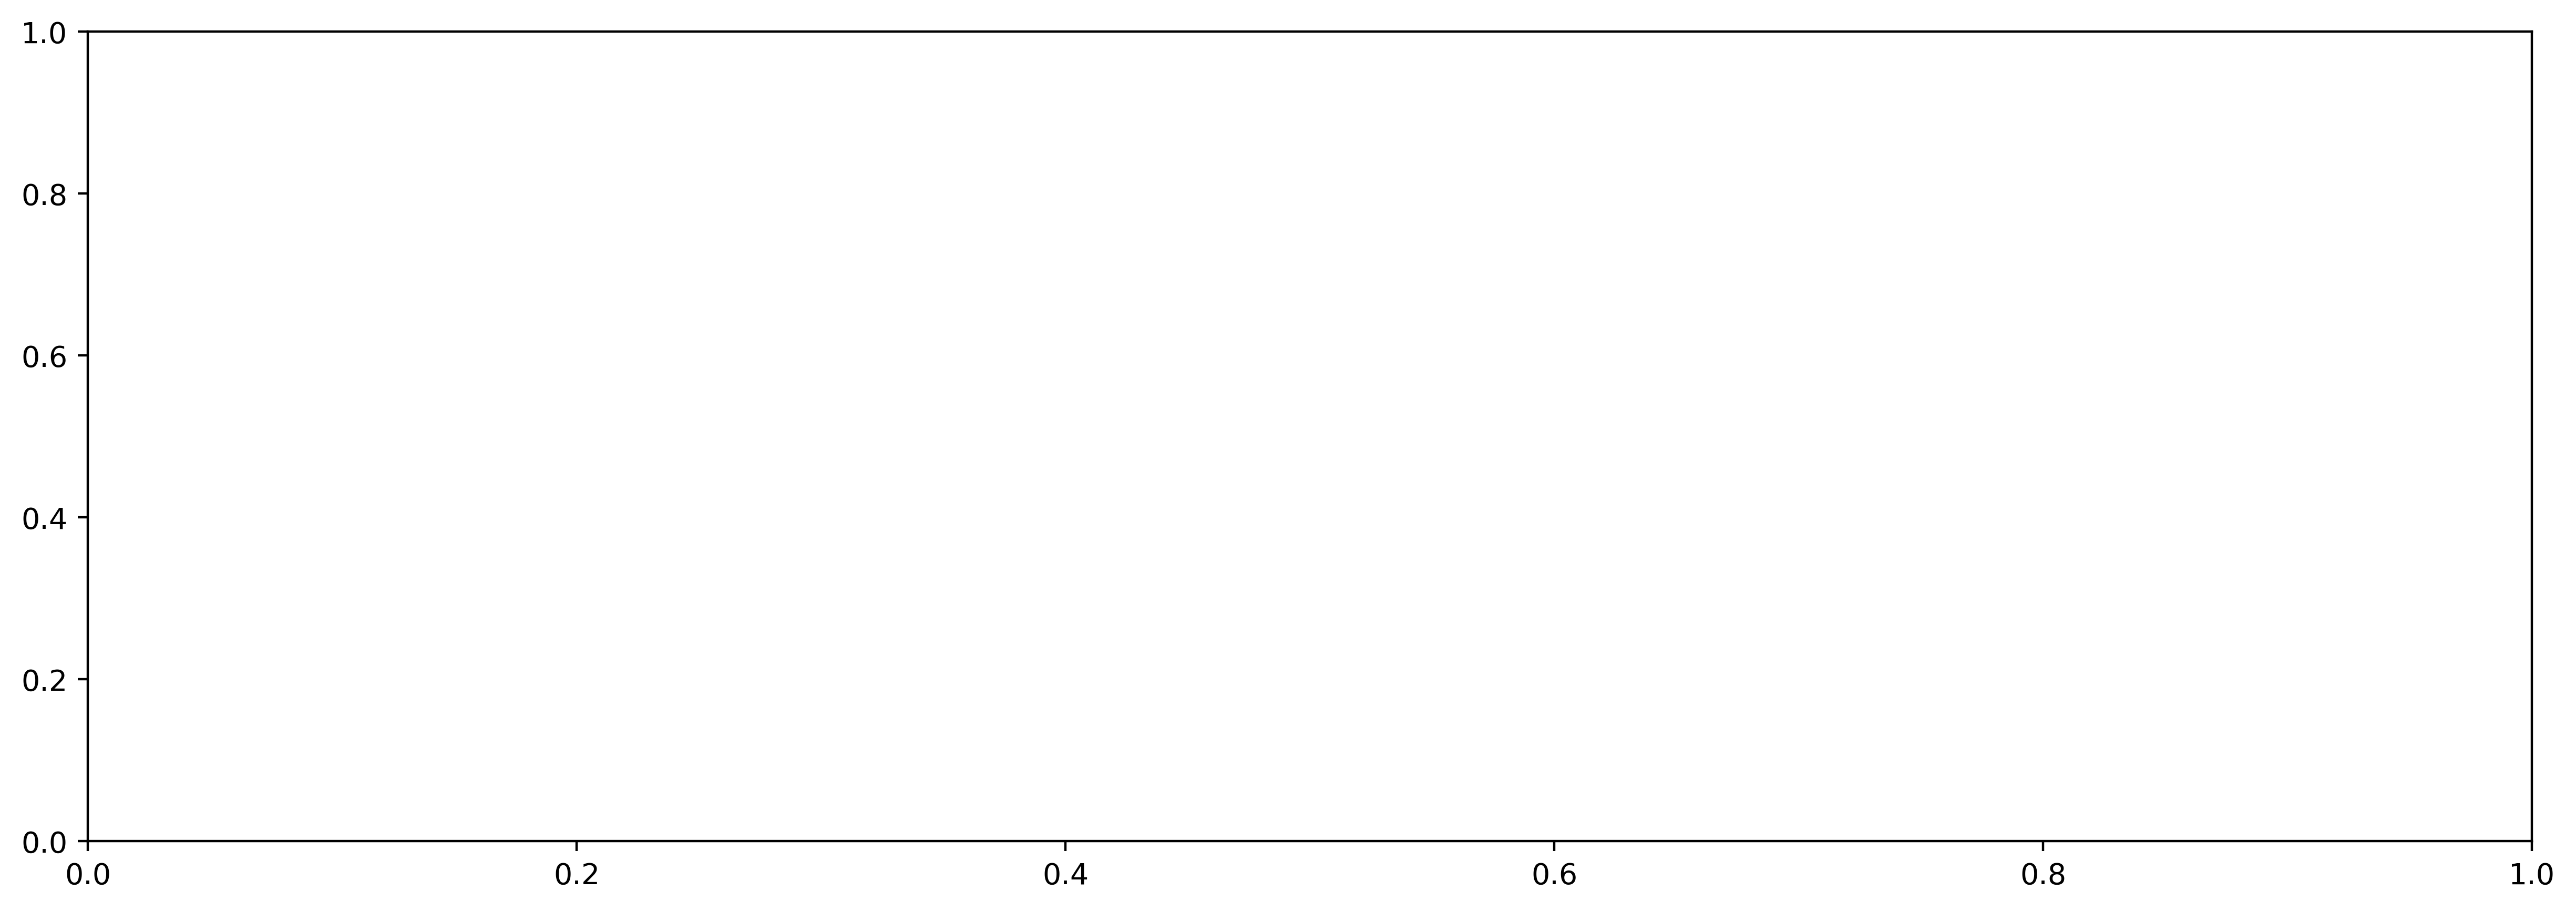

In [12]:
model.results.plot()

In [8]:
model.load_model(model_file="./results/test/20230419_221319.pth")

[    INFO    ] Model loaded from: ./results/test/20230419_221319.pth


In [42]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import pandas as pd
from torchvision.io import read_image
from torch import nn

In [28]:
pred = [
    model.predict(data["train"].iloc[i].img, transform=transform["train"])
    .detach()
    .numpy()
    .flatten()
    for i in tqdm(range(0, data["train"].shape[0], 10))
]

  0%|          | 0/629 [00:00<?, ?it/s]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 629 samples in 0.000s...
[t-SNE] Computed neighbors for 629 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 629 / 629
[t-SNE] Mean sigma: 50.601285
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.683758
[t-SNE] KL divergence after 300 iterations: 0.593221


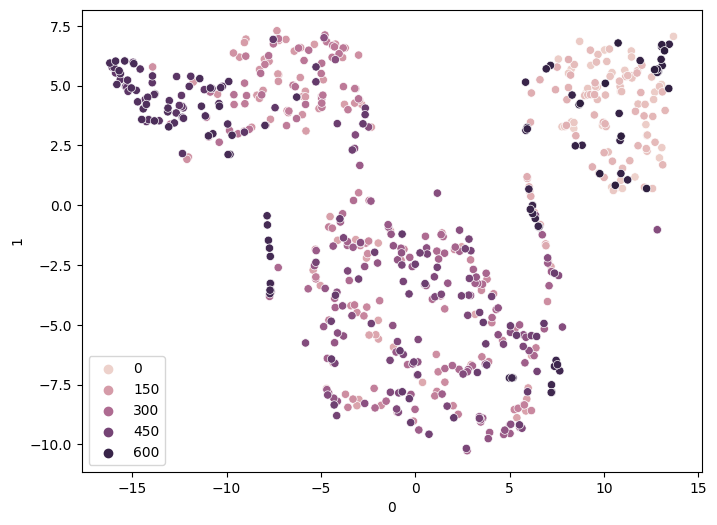

In [29]:
pca = PCA(n_components=50)
res_pca = pca.fit_transform(np.array(pred))
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
res_tsne = pd.DataFrame(tsne.fit_transform(res_pca))
_, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=res_tsne, x=0, y=1, hue=res_tsne.index, ax=ax)
plt.show()

In [34]:
np.argmin(res_tsne[1])

327

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1401)


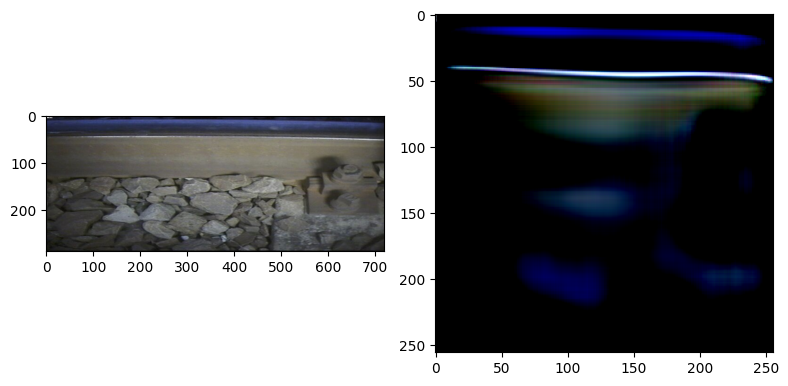

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1230)


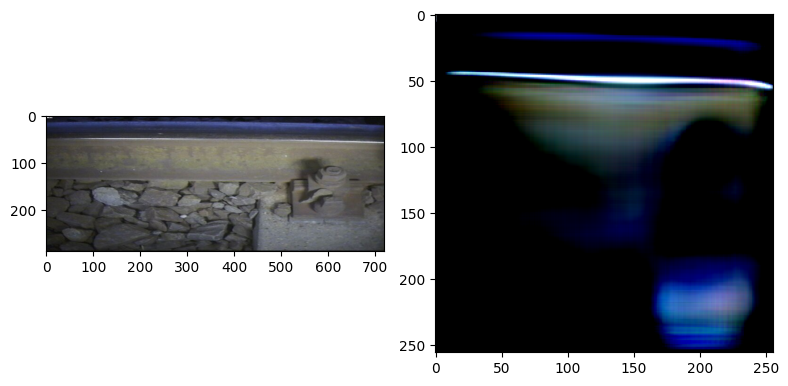

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1322)


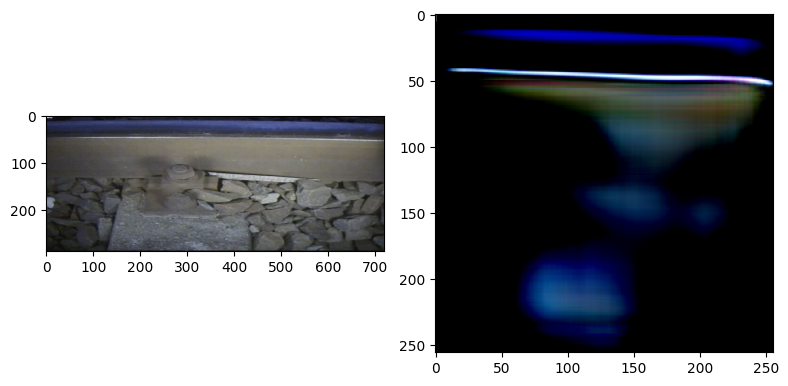

In [48]:
for idx in [556, 327, 7]:
    img_true = data["train"].iloc[idx].img
    img_pred = model.predict(img_true, transform=transform["train"])
    img_pred = torch.squeeze(img_pred)
    print(
        nn.MSELoss()(
            img_pred, transform["train"](read_image(img_true))
        )
    )
    _, ax = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True)
    ax[0].imshow(read_image(img_true).permute(1, 2, 0).detach().numpy())
    ax[1].imshow(img_pred.permute(1, 2, 0).detach().numpy())
    plt.show()

In [37]:
pred2 = []
for i in tqdm(range(0, data["train"].shape[0], 10)):
    img = read_image(data["train"].iloc[i].img)
    transformed_img = transform["train"](img)
    transformed_img = torch.unsqueeze(transformed_img, 0)
    model.eval()
    with torch.no_grad():
        out = model.encoder(transformed_img).detach().numpy().flatten()
    pred2.append(out)


  0%|          | 0/629 [00:00<?, ?it/s]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 629 samples in 0.002s...
[t-SNE] Computed neighbors for 629 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 629 / 629
[t-SNE] Mean sigma: 5318.100551
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.328568
[t-SNE] KL divergence after 300 iterations: 0.713332


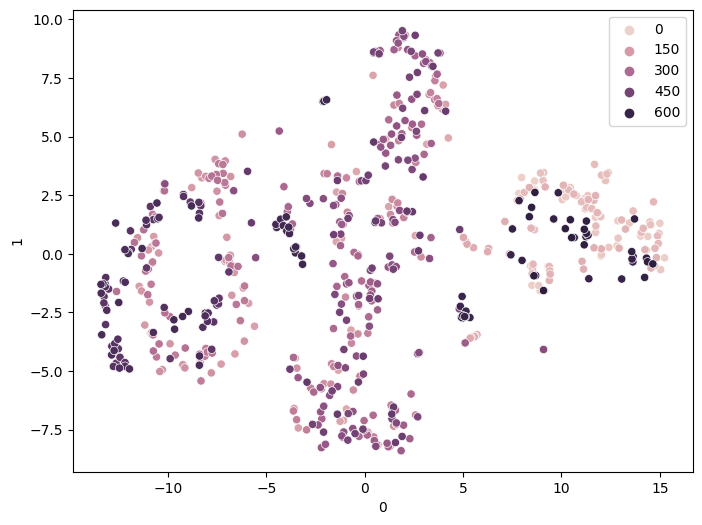

In [39]:
pca = PCA(n_components=50)
res_pca = pca.fit_transform(np.array(pred2))
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
res_tsne = pd.DataFrame(tsne.fit_transform(res_pca))
_, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=res_tsne, x=0, y=1, hue=res_tsne.index, ax=ax)
plt.show()

In [40]:
np.argmin(res_tsne[0]), np.argmax(res_tsne[0]), np.argmin(res_tsne[1]), np.argmax(res_tsne[1])

(558, 9, 353, 452)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


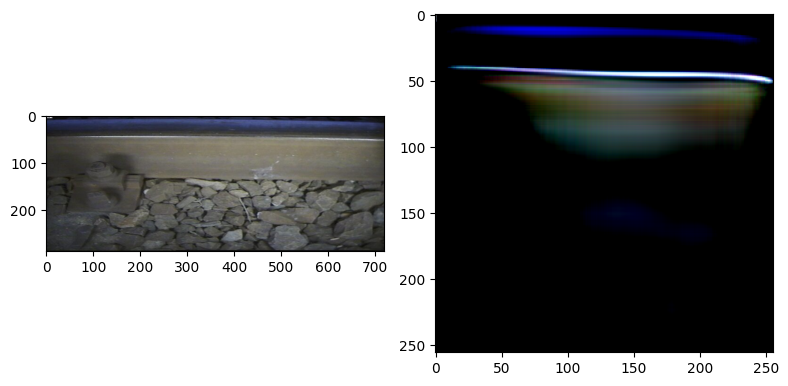

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


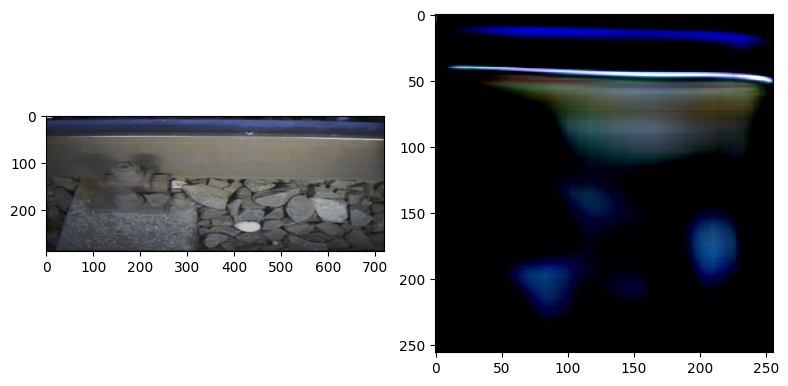

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


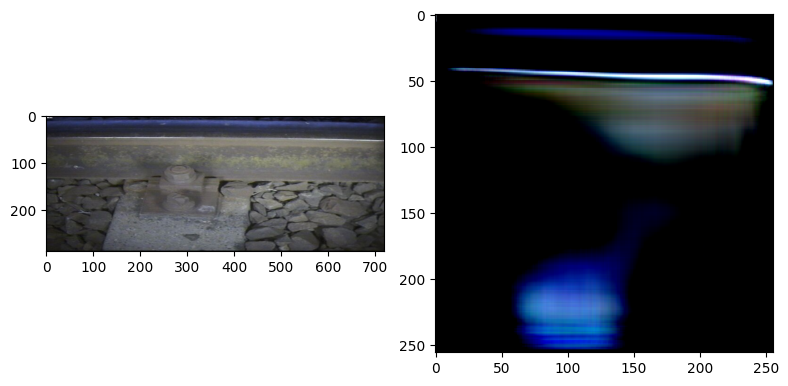

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


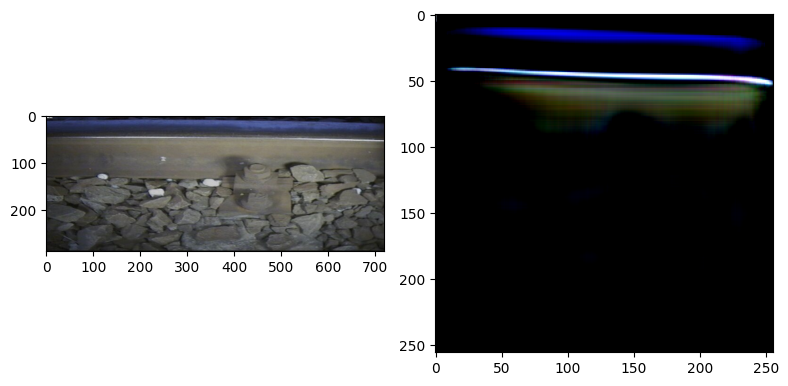

In [41]:
for idx in [558, 9, 353, 452]:
    img_true = data["train"].iloc[idx].img
    img_pred = model.predict(img_true, transform=transform["train"])
    img_pred = torch.squeeze(img_pred)

    _, ax = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True)
    ax[0].imshow(read_image(img_true).permute(1, 2, 0).detach().numpy())
    ax[1].imshow(img_pred.permute(1, 2, 0).detach().numpy())
    plt.show()